<a href="https://colab.research.google.com/github/sysgenerated/real-estate/blob/main/real_estate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Overview

1. Load dataset
  1. Data was saved to Google Drive and loaded to Google Colab
2. Explore training dataset
  1. Review dataset for nulls
  2. Describe dataset and review correlation matrix
  3. Identify predictors and target
  4. Plot normality for each predictor
    1. All predictors are already normalized
3. Create train / test datesets
  1. Upsample training dataset and compare to test set
4. Train and validate a test model
  1. Identify optimal threshold using F1 score
5. Train a final model
  1. Upsample full dataset 
  2. Use all available data to train a production model

## 0. Set up compute environment
1. Mount Google Drive
2. Load standard libraries
3. Create plotting functions

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Import standard libraries
import pandas as pd
import numpy as np
import joblib

# Import plotting utilities
import matplotlib.pyplot as plt
import seaborn as sns
import plotnine
from plotnine import *
plt.style.use('seaborn-whitegrid')

# Import model libraries
from sklearn import set_config
from sklearn.metrics import auc, f1_score, precision_recall_curve, r2_score 
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.over_sampling import RandomOverSampler
from xgboost import XGBClassifier

In [3]:
# Create reusable plotting functions
def plot_scatter_box(x, y):
  plt.subplots(figsize=(10, 5))

  plt.subplot(1, 2, 1) # row 1, column 2, item 1
  plt.scatter(x=x, y=y)
  plt.title('Scatterplot')
  plt.xlabel(x.name)
  plt.ylabel(y.name)
  # plt.text(50, 5000, f'$R^2$ Value = {r2_score(x, y):.2%}')

  plt.subplot(1, 2, 2)
  plt.title('Boxplot')
  pd.concat([x, y], axis=1).boxplot() 

  plt.tight_layout(4)

  plt.show()


def plot_frequency_histogram(x):
  x.value_counts().plot(kind='bar')
  plt.title(x.name)
  plt.show()

## 1. Load dataset

In [4]:
# Import the dataset
df = pd.read_csv('/content/drive/MyDrive/real-estate/listing_churn_data.csv')
df.head()

,avg_interactions_with_support,owner_blocks_per_month,avg_income_last_12,avg_income_last_6,avg_review_score,number_of_reviews,bookings_per_month,weekends_booked_per_month,avg_nightly_rate,avg_length_of_stay,churn
0,0.617163,9.577551,3814.028288,5426.263674,2.057209,15.310482,6.807388,2.000974,112.447254,2.251096,0
1,0.806455,8.798974,4206.420776,4655.139391,2.688184,12.099859,11.036336,1.745107,162.364418,1.963245,0
2,0.782139,7.734795,4552.123937,3851.009952,2.607130,12.348177,9.001582,1.961279,362.219228,2.206438,0
3,0.718405,8.326465,2678.914523,3593.631638,2.394683,13.332082,6.156692,2.155884,284.710399,2.425369,0
4,0.449931,9.654206,3152.906971,4352.544162,1.499769,17.709455,5.898279,2.715650,219.075644,3.055107,0


## 2. Explore training dataset

All features are continuous with no missing values. All predictors are positive with a lower bound of zero.

Target:
* churn: target boolean indicator, imbalanced data with less than 7% in minority class

Remove features:
* avg_interactions_with_support: remove due to perfect correlation with avg_review_score
* weekends_booked_per_month: remove due to perfect correlation with avg_length_of_stay
* number_of_reviews: remove due to high correlation with avg_review_score

Keep features:
* owner_blocks_per_month: highly normal predictor, uncorrelated with other predictors
* avg_income_last_12: highly normal predictor, uncorrelated with other predictors
* avg_income_last_6: highly normal predictor, uncorrelated with other predictors
* avg_review_score: correlated with avg_length_of_stay but will be retained
* bookings_per_month: highly normal predictor
* avg_nightly_rate: highly normal predictor, uncorrelated with other predictors
* avg_length_of_stay: 



In [5]:
# Check for nulls
df.isnull().sum()

avg_interactions_with_support    0
owner_blocks_per_month           0
avg_income_last_12               0
avg_income_last_6                0
avg_review_score                 0
number_of_reviews                0
bookings_per_month               0
weekends_booked_per_month        0
avg_nightly_rate                 0
avg_length_of_stay               0
churn                            0
dtype: int64

In [6]:
# Identify summary statistics for the dataset and suppress scientific notation
df.describe().apply(lambda s: s.apply('{0:.5f}'.format))

,avg_interactions_with_support,owner_blocks_per_month,avg_income_last_12,avg_income_last_6,avg_review_score,number_of_reviews,bookings_per_month,weekends_booked_per_month,avg_nightly_rate,avg_length_of_stay,churn
count,125000.00000,125000.00000,125000.00000,125000.00000,125000.00000,125000.00000,125000.00000,125000.00000,125000.00000,125000.00000,125000.00000
mean,0.67808,7.72532,3963.24005,4599.63004,2.26025,14.10674,7.87045,2.10916,242.81268,2.37281,0.06698
std,0.14785,1.68716,967.13986,1022.53873,0.49285,2.42651,1.69293,0.34297,48.43941,0.38584,0.24998
min,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
25%,0.57870,6.58781,3313.67585,3908.43421,1.92900,12.54784,6.72465,1.88124,210.27862,2.11640,0.00000
50%,0.67555,7.73075,3964.77809,4602.62515,2.25184,14.15939,7.86845,2.11003,242.79566,2.37378,0.00000
75%,0.77426,8.86080,4616.41859,5286.37076,2.58087,15.73212,9.01135,2.33789,275.73686,2.63013,0.00000
max,1.50000,15.00000,8000.00000,9500.00000,5.00000,25.00000,15.00000,4.00000,450.00000,4.50000,1.00000


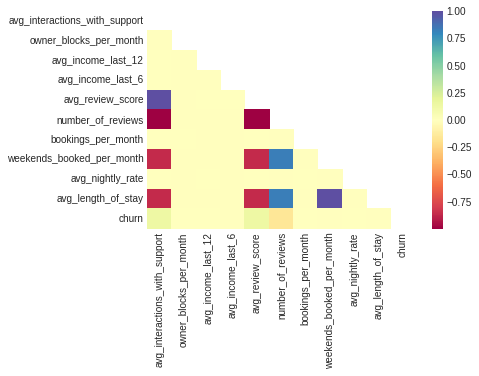

In [7]:
# Create a lower triangular correlation heatmap
corr_df =  df.corr(method='pearson') 
mask_ut=np.triu(np.ones(corr_df.shape)).astype(bool)
sns.heatmap(corr_df, mask=mask_ut, cmap="Spectral");

In [8]:
# Print correlations
corr_df 

,avg_interactions_with_support,owner_blocks_per_month,avg_income_last_12,avg_income_last_6,avg_review_score,number_of_reviews,bookings_per_month,weekends_booked_per_month,avg_nightly_rate,avg_length_of_stay,churn
avg_interactions_with_support,1.000000,0.000494,0.002294,0.001193,1.000000,-0.997961,0.001804,-0.863509,0.002922,-0.863509,0.133712
owner_blocks_per_month,0.000494,1.000000,-0.001632,-0.004223,0.000494,-0.000614,0.004907,0.000531,-0.002568,0.000531,0.002609
avg_income_last_12,0.002294,-0.001632,1.000000,0.000273,0.002294,-0.002216,-0.002857,-0.002555,0.003089,-0.002555,0.002630
avg_income_last_6,0.001193,-0.004223,0.000273,1.000000,0.001193,-0.001075,-0.002638,-0.001942,0.000731,-0.001942,-0.001686
avg_review_score,1.000000,0.000494,0.002294,0.001193,1.000000,-0.997961,0.001804,-0.863509,0.002922,-0.863509,0.133712
number_of_reviews,-0.997961,-0.000614,-0.002216,-0.001075,-0.997961,1.000000,-0.002121,0.829561,-0.002984,0.829561,-0.147947
bookings_per_month,0.001804,0.004907,-0.002857,-0.002638,0.001804,-0.002121,1.000000,0.000973,0.003733,0.000973,0.001804
weekends_booked_per_month,-0.863509,0.000531,-0.002555,-0.001942,-0.863509,0.829561,0.000973,1.000000,-0.001984,1.000000,-0.000822
avg_nightly_rate,0.002922,-0.002568,0.003089,0.000731,0.002922,-0.002984,0.003733,-0.001984,1.000000,-0.001984,0.003209
avg_length_of_stay,-0.863509,0.000531,-0.002555,-0.001942,-0.863509,0.829561,0.000973,1.000000,-0.001984,1.000000,-0.000822


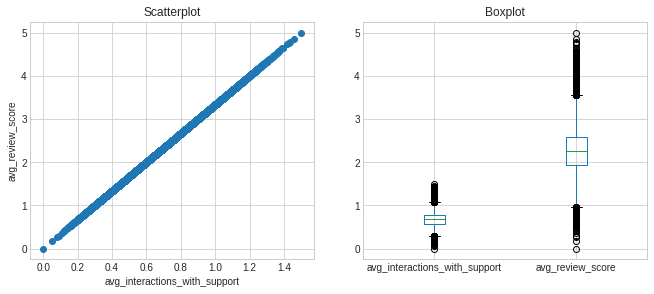

In [9]:
# Compare perfectly correlated features
plot_scatter_box(x=df['avg_interactions_with_support'], y=df['avg_review_score'])

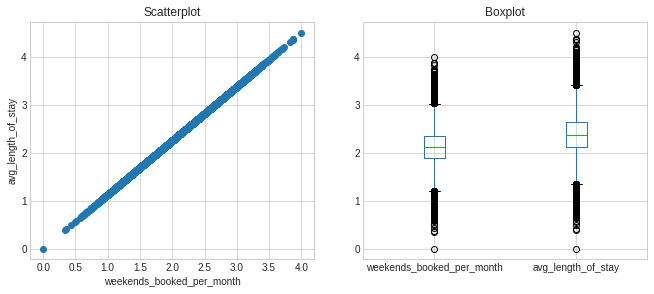

In [10]:
# Compare perfectly correlated features
plot_scatter_box(x=df['weekends_booked_per_month'], y=df['avg_length_of_stay'])

In [11]:
# Identify predictors and target if train/test is used
predictors = ['owner_blocks_per_month', 'avg_income_last_12', 'avg_income_last_6', 'avg_review_score',
              'bookings_per_month', 'avg_nightly_rate', 'avg_length_of_stay']

target = 'churn'

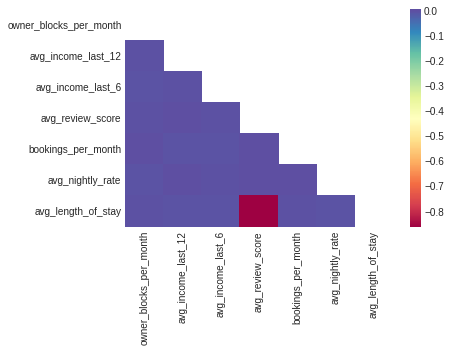

In [12]:
# Create a lower triangular correlation heatmap after removing perfectly correlated predictors
corr_df =  df[predictors].corr(method='pearson') 
mask_ut=np.triu(np.ones(corr_df.shape)).astype(bool)
sns.heatmap(corr_df, mask=mask_ut, cmap="Spectral");

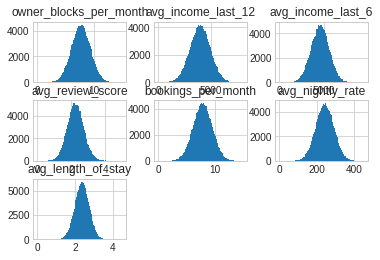

In [13]:
# Histogram of remaining predictors
df[predictors].hist(bins=100);

## 3. Prepare train / test data

1. Create train / test data
2. Upsample minority class in training set

In [14]:
# Extract target and predictors into full dataset
X_full = df[predictors]
y_full = df[target]

# Create train / test splits stratified by the target
X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, test_size=0.2, random_state=0, stratify=y_full)

# Upsample the minority class for training
ros = RandomOverSampler(random_state=0)
X_train, y_train = ros.fit_resample(X_train, y_train)

## 4. Train / Validate a model

Train on upsampled data and then use a test set to calculate the optimal threshold.

In [15]:
# Use XGB as a standard model
model = XGBClassifier(n_estimators=900, learning_rate=0.2, max_depth=9)

# param_grid = {
#     'n_estimators': [300, 500, 700, 900],
#     'learning_rate': [0.05, 0.1, 0.2],
#     'max_depth': [5, 7, 9],
#     'subsample': [0.4, 0.5, 1.0]}

# model = GridSearchCV(model, param_grid, n_jobs=-1)
# model.fit(X_train, y_train)
# print(model.best_params_)

model.fit(X_train, y_train)

XGBClassifier(learning_rate=0.2, max_depth=9, n_estimators=900)

Best Threshold: 0.5378999710083008 with F-Score: 0.3367
Recall: 0.218, Precision: 0.7389


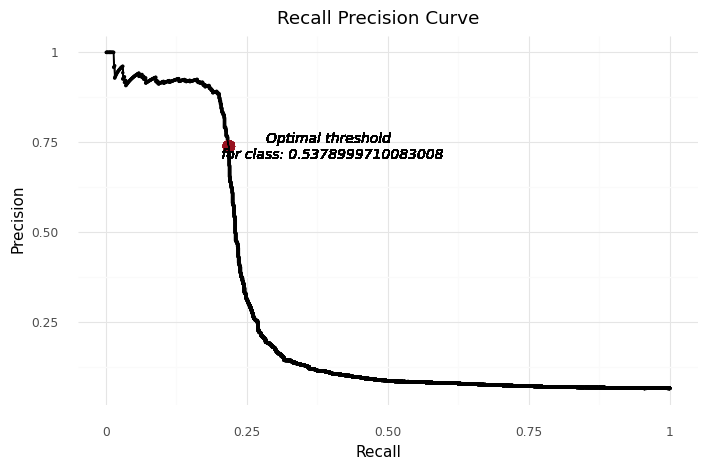

<ggplot: (8791841291657)>

In [16]:
# Create predictions
y_pred = model.predict_proba(X_test)[:,1]

# Calculate precision and recall
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)

# Create precision recall dataframe
df_recall_precision = pd.DataFrame({'Precision':precision[:-1],
                                    'Recall':recall[:-1],
                                    'Threshold':thresholds})

# Calculate the f-score
fscore = (2 * precision * recall) / (precision + recall)



### This code reused from https://towardsdatascience.com/optimal-threshold-for-imbalanced-classification-5884e870c293

# Find the optimal threshold
index = np.argmax(fscore)
thresholdOpt = round(thresholds[index], ndigits = 4)
fscoreOpt = round(fscore[index], ndigits = 4)
recallOpt = round(recall[index], ndigits = 4)
precisionOpt = round(precision[index], ndigits = 4)
print('Best Threshold: {} with F-Score: {}'.format(thresholdOpt, fscoreOpt))
print('Recall: {}, Precision: {}'.format(recallOpt, precisionOpt))

# Graph 
plotnine.options.figure_size = (8, 4.8)
(
    ggplot(data = df_recall_precision)+
    geom_point(aes(x = 'Recall',
                   y = 'Precision'),
               size = 0.4)+
    # Best threshold
    geom_point(aes(x = recallOpt,
                   y = precisionOpt),
               color = '#981220',
               size = 4)+
    geom_line(aes(x = 'Recall',
                  y = 'Precision'))+
    # Annotate the text
    geom_text(aes(x = recallOpt,
                  y = precisionOpt),
              label = 'Optimal threshold \n for class: {}'.format(thresholdOpt),
              nudge_x = 0.18,
              nudge_y = 0,
              size = 10,
              fontstyle = 'italic')+
    labs(title = 'Recall Precision Curve')+
    xlab('Recall')+
    ylab('Precision')+
    theme_minimal()
)

## 5. Train a final model

In [17]:
# For the final model upsample the full dataset
X_final, y_final = ros.fit_resample(X_full, y_full)

# Train a model using the full dataset and best parameters
model = XGBClassifier()
model.fit(X_final, y_final)
joblib.dump(model, 'model_20220308.joblib')

['model_20220308.joblib']